# Deep learning forecasting with DARTS

Using the N-BEATS model: Neural Basis Expansion Analysis Time Series Forecasting 

* **Training a DL model on in mulitple, multivariate series**


In [14]:
# General Imports
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline     

# Forecasting imports
from darts.models import NBEATSModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.utils import SeasonalityMode
from darts import TimeSeries
from darts.metrics import mae, mape
from darts.dataprocessing.transformers import Scaler
# from darts.utils.statistics import extract_trend_and_seasonality, remove_trend

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters


In [3]:
sites = [
    'Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Daily.nc',
    'CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Daily.nc',
    'Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Daily.nc',
    'WombatStateForest/2022_v1/L6/default/WombatStateForest_L6_20100120_20210529_Daily.nc'
]

var = ['GPP_SOLO', 'Ta', 'VPD','Precip', 'ET', 'Fsd']
var_names = ['GPP','Ta', 'VPD', 'precip', 'ET', 'solar']
# test_split=0.80

n=12

## Load data

Training a DL model on in mulitple, multivariate series.

Using the first three sites to train a model, then predicting on a fourth site.

In [4]:
def VPD(rh, ta):
    sat_vp = (6.11 * np.exp((2500000/461) * (1/273 - 1/(273 + ta))))
    vpd = (((100 - rh)/100) * sat_vp)
    return vpd

# l
series_all=[]
for site in sites: 
    ds = xr.open_dataset('https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/'+site)
    ds['GPP_SOLO'] = xr.where(ds.GPP_SOLO < 0, 0, ds.GPP_SOLO)  #Set negative GPP, ER, and ET measurements as zero
    ds['ER_SOLO'] = xr.where(ds.ER_SOLO < 0, 0, ds.ER_SOLO)  #Set negative GPP, ER, and ET measurements as zero
    ds['ET'] = xr.where(ds.ET < 0, 0, ds.ET)  #Set negative GPP, ER, and ET measurements as zero
    ds['VPD'] = VPD(ds.RH, ds.Ta)
    ds = ds[var]

    # anomalization
    # ds_clim_mean = ds.groupby('time.month').mean()
    # ds = (ds.groupby('time.month') - ds_clim_mean)

    ds = ds.resample(time='1W').mean()
    df = ds.to_dataframe().reset_index(
            level=[1, 2]).drop(['latitude', 'longitude'], axis=1)
    df = df[var].dropna()
    series = TimeSeries.from_dataframe(df) 
    series_all.append(series)

#split into train/test sammples
train = series_all[0:-1]
test = series_all[-1]

## Fit a model on training dataset

Scaling data before fitting

<!-- # RNN Model
# model = BlockRNNModel(
#     model="LSTM",
#     input_chunk_length=int(len(df)/3),
#     output_chunk_length=3,
#     pl_trainer_kwargs={'accelerator':'cuda', 'devices':1} #use GPUs
# )

# model = TCNModel(
#     input_chunk_length=int(len(df)/3),
#     output_chunk_length=3
# )

# model = LightGBMModel(lags=3, lags_past_covariates=3, output_chunk_length=3, likelihood='quantile')
# model = LinearRegressionModel(lags=3, lags_past_covariates=3, output_chunk_length=3, likelihood='quantile') -->

In [ ]:
# scaler = Scaler()
# series_gpp_scaled = scaler.fit_transform(series_gpp)

# scaler_cov = Scaler()
# covariates = scaler_cov.fit_transform(covariates)

In [16]:
%%time

# idx = int(len(series_gpp_scaled)*test_split)
# train, val = series_all.split_after(pd.Timestamp(series_all[idx].data_array().time.values[0]))
# cov_train, cov_val = covariates.split_after(pd.Timestamp(series_gpp[idx].data_array().time.values[0]))

# covariables as enconders
encoders = {
    # "cyclic": {"future": ["month"]},
    "datetime_attribute": {"past":["week", "month", "year"]},
    # "position": {"past": ["absolute"], "future": ["relative"]},
    "transformer": Scaler(),
}

model = NBEATSModel(input_chunk_length=104,
                    output_chunk_length=n,
                    generic_architecture=False,
                    likelihood=QuantileRegression(),
                    random_state=0,
                    n_epochs=80,
                    add_encoders=encoders,
                    pl_trainer_kwargs={'accelerator':'cpu'} #use CPUs
                    # pl_trainer_kwargs={'accelerator':'cuda', 'devices':1,} #use GPUs
                   )

model.fit(train)

2022-08-22 14:12:32 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 2472 samples.
2022-08-22 14:12:32 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-08-22 14:12:33 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-08-22 14:12:33 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-22 14:12:33 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-22 14:12:33 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-08-22 14:12:33 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.5 M 
-

Training: 0it [00:00, ?it/s]

2022-08-22 14:21:45 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=80` reached.


CPU times: user 1h 41min 43s, sys: 46.4 s, total: 1h 42min 30s
Wall time: 9min 13s


## Predict on validation dataset

In [17]:
# pred = model.predict(n=len(val), series=train[], num_samples=100) #past_covariates=covariates

# pred_r = scaler.inverse_transform(pred)
# val_r = scaler.inverse_transform(val)
# err = mape(val_r['GPP_SOLO'], pred_r['GPP_SOLO'])

# fig,ax = plt.subplots(figsize=(15,5))
# series_gpp['GPP_SOLO'].plot(ax=ax, label='actual')

# pred_r['GPP_SOLO'].plot(ax=ax, lw=3,
#                                     label='{}, MAPE={:.2f} %'.format('Forecast', err))
# plt.ylabel(var_names[0]+', gC/m2/week')
# # plt.axhline(0, color='grey')
# plt.legend()

### Iterative backtest on site held out of traininig

In [18]:
backtests = model.historical_forecasts(test,
                                       # past_covariates=covariates,
                                       num_samples=100,
                                       start=.5,
                                       retrain=False,
                                       forecast_horizon=n,
                                       stride=1,
                                       verbose=True
                                      )


  0%|          | 0/286 [00:00<?, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

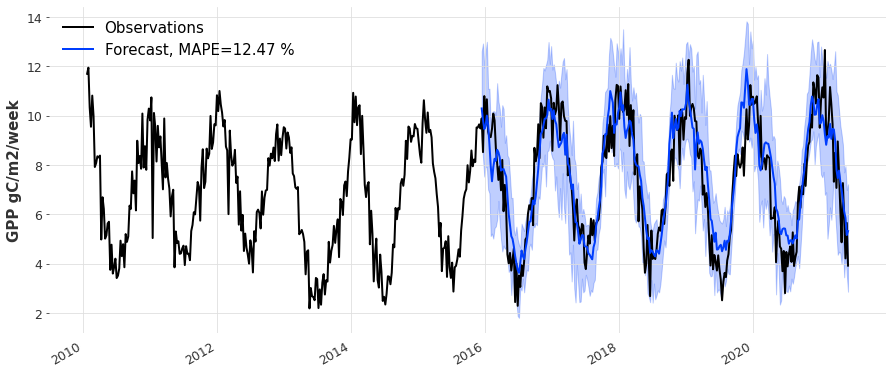

In [19]:
plt.rcParams.update({'font.size': 15})
# backtests = scaler.inverse_transform(backtests)

fig,ax = plt.subplots(figsize=(15,6))
test['GPP_SOLO'].plot(ax=ax, lw=2, label='Observations')

err = mape(backtests[['GPP_SOLO']], test[['GPP_SOLO']])

backtests['GPP_SOLO'].plot(ax=ax, lw=2, label='{}, MAPE={:.2f} %'.format('Forecast', err), low_quantile=.05, high_quantile=0.95)
plt.ylabel(var_names[0]+' gC/m2/week')
plt.xlabel('')
# plt.title('Backtests with 12-week forecast horizon')
# plt.axvline(pd.Timestamp(test[idx].data_array().time.values[0]), color='red', linestyle='--')
plt.legend()

## Forecast the future

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

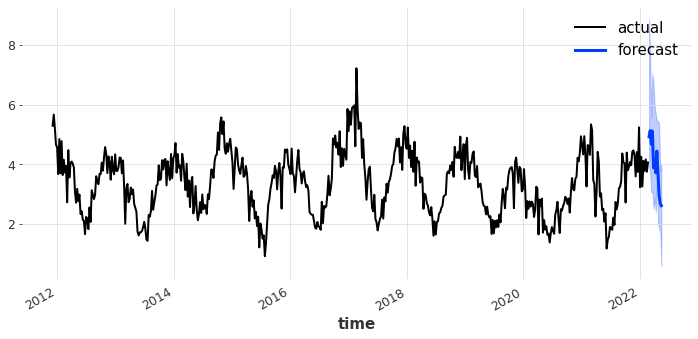

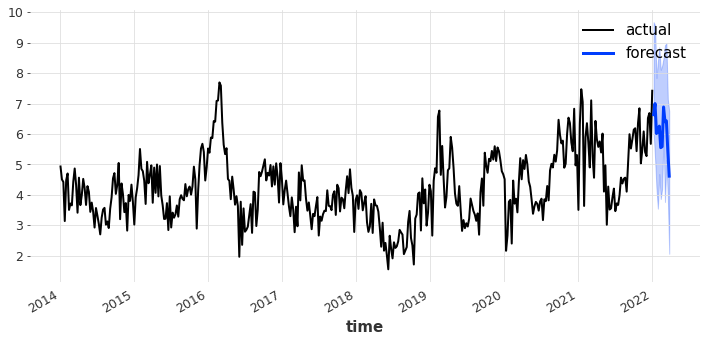

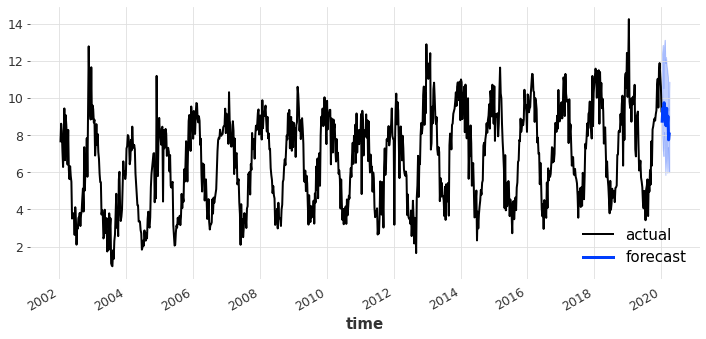

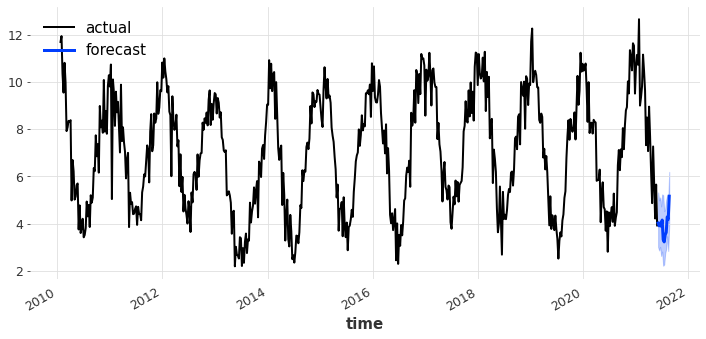

In [21]:
#refit the model on all the data
fig, axes = plt.subsplots(2,2):

for t, ax in zip(series_all):
    #model.fit(t) # past_covariates=covariates

    #forecast the future
    pred = model.predict(n=n,
                         series=t,
                         num_samples=100
                        )
    
    #pred_r = scaler.inverse_transform(pred)
    fig,ax = plt.subplots(figsize=(12,5))
    t['GPP_SOLO'].plot(ax=ax, label='actual')
    pred['GPP_SOLO'].plot(ax=ax, label='forecast', lw=3)
    plt.legend()

In [ ]:
'

In [25]:
ds = xr.open_dataset('https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/'+'Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Daily.nc')
ds['GPP_SOLO'] = xr.where(ds.GPP_SOLO < 0, 0, ds.GPP_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ER_SOLO'] = xr.where(ds.ER_SOLO < 0, 0, ds.ER_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ET'] = xr.where(ds.ET < 0, 0, ds.ET)  #Set negative GPP, ER, and ET measurements as zero
ds['VPD'] = VPD(ds.RH, ds.Ta)
ds = ds[var]

# anomalization
# ds_clim_mean = ds.groupby('time.month').mean()
# ds = (ds.groupby('time.month') - ds_clim_mean)

ds = ds.resample(time='1W').mean()
df = ds.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude'], axis=1)
df = df[var].dropna()
series = TimeSeries.from_dataframe(df)

In [26]:
backtests = model.historical_forecasts(series,
                                       # past_covariates=covariates,
                                       num_samples=100,
                                       start=.5,
                                       retrain=False,
                                       forecast_horizon=n,
                                       stride=1,
                                       verbose=True
                                      )


  0%|          | 0/231 [00:00<?, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

Predicting: 78it [00:00, ?it/s]

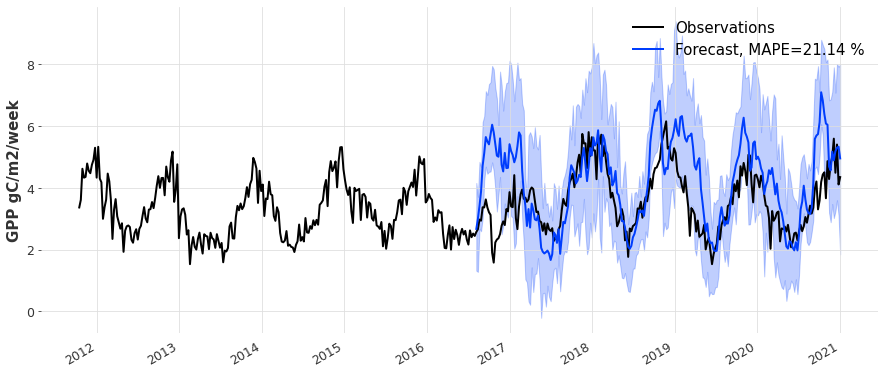

In [27]:
fig,ax = plt.subplots(figsize=(15,6))
series['GPP_SOLO'].plot(ax=ax, lw=2, label='Observations')

err = mape(backtests[['GPP_SOLO']], series[['GPP_SOLO']])

backtests['GPP_SOLO'].plot(ax=ax, lw=2, label='{}, MAPE={:.2f} %'.format('Forecast', err), low_quantile=.05, high_quantile=0.95)
plt.ylabel(var_names[0]+' gC/m2/week')
plt.xlabel('')
# plt.title('Backtests with 12-week forecast horizon')
# plt.axvline(pd.Timestamp(test[idx].data_array().time.values[0]), color='red', linestyle='--')
plt.legend()

## Cuts

---

### Per pixel time-series

In [ ]:
# gpp=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc').drop('spatial_ref')
# rain=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/chirps_5km_monthly_1991_2021.nc').drop('spatial_ref').sel(time=slice('2002', '2021'))

# gpp=gpp.isel(latitude=slice(300,305), longitude=slice(300,305))
# rain=rain.isel(latitude=slice(300,305), longitude=slice(300,305))

# # da=da.stack(component=('latitude', 'longitude'))
# # da = da.expand_dims({'sample':1}, axis=-1)
# # da['time'] = da['time'].astype("datetime64[M]")
# # df_in = TimeSeries.from_xarray(da)

# def process(df):
#     df = df.reset_index()
#     df['time'] = df['time'].astype("datetime64[M]")
#     df = df.set_index('time')
#     return df

# tss = []
# i=0
# shape = gpp.shape
# #loop through pixels
# for i in range(shape[1]):
#     for j in range(shape[2]):
#         gpp_df = gpp.isel(latitude=i, longitude=j).drop(['latitude', 'longitude']).to_dataframe()
#         rain_df = rain.isel(latitude=i, longitude=j).drop(['latitude', 'longitude']).to_dataframe()
#         gpp_df = process(gpp_df)
#         rain_df = process(rain_df)
#         df = pd.concat([gpp_df,rain_df], join='inner', axis=1)
#         ts = TimeSeries.from_dataframe(df)
#         covariates = datetime_attribute_timeseries(ts.time_index, attribute="week")
#         covariates = covariates.stack(datetime_attribute_timeseries(ts.time_index, attribute="month"))
#         covariates = covariates.stack(datetime_attribute_timeseries(ts.time_index, attribute="year"))
#         ts = ts.stack(covariates)
#         tss.append(ts)
#         # i+=1
#     i+=1*shape[2]
#     print(" {:04}/{:04}\r".format(i, shape[1]*shape[2]), end="")